# **Feedback Data - Sentiment Analysis**


### Install and Import dependencies







In [102]:
#!pip install --quiet openai pandas tqdm


In [103]:
#pip install openai==0.28

In [104]:
#pip install nlpaug


In [105]:
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import io, pandas as pd, os, random, time
import os, getpass
from typing import List
import pandas as pd

import nlpaug.augmenter.word as naw

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import pandas as pd, torch, numpy as np
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from scipy.special import softmax
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc)

#### Load Data

In [106]:
#Replace with local feedback.csv file path
file_path = Path("/content/drive/MyDrive/feedback_data.csv")
df = pd.read_csv(file_path)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Feedback   51 non-null     object
 1   Sentiment  51 non-null     object
dtypes: object(2)
memory usage: 948.0+ bytes


In [107]:
df.head()

,Feedback,Sentiment
0,The information was very helpful and easy to n...,Positive
1,I found the website confusing and hard to use.,Negative
2,"Great job on the user interface, very intuitive!",Positive
3,The page loads are too slow and it frustrates ...,Negative
4,Thanks for providing up-to-date information!,Positive


### Exploratory Data Analysis

#### Duplicate Row

In [108]:
# Duplicate checks
duplicates = df.duplicated(subset="Feedback").sum()
print(f"\nDuplicate feedback rows: {duplicates}")
print(df[df.duplicated(subset='Feedback')])


Duplicate feedback rows: 1
                                             Feedback Sentiment
49  The page loads are too slow and it frustrates ...  Negative


In [109]:
#drop duplicated row and display df sape

df.drop_duplicates(subset="Feedback", inplace=True)
print(f"DataFrame shape after dropping duplicates: {df.shape}")

DataFrame shape after dropping duplicates: (50, 2)


####Value counts



In [110]:
sentiment_counts = df["Sentiment"].value_counts()
print("\n--- Sentiment distribution ---")
print(sentiment_counts)



--- Sentiment distribution ---
Sentiment
Negative    26
Positive    24
Name: count, dtype: int64


####Word Frequency

In [111]:
CUSTOM_STOPWORDS = {
    "the", "and", "to", "a", "of", "was", "is", "it", "in", "for", "on",
    "with", "that", "this", "as", "at", "an", "be", "are", "but", "so",
    "we", "our", "i", "you", "not", "very", "too", "me"
}

def clean_tokenise(text: str) -> list[str]:
    """Lowercase, strip punctuation, split and drop stop‑words."""
    text = re.sub(r"[^\w\s]", " ", text.lower())
    tokens = text.split()
    return [tok for tok in tokens if tok not in CUSTOM_STOPWORDS]

df["tokens"] = df["Feedback"].apply(clean_tokenise)

def freq(tokens_list: list[list[str]], top_n: int = 20) -> list[tuple[str, int]]:
    all_words = (tok for toks in tokens_list for tok in toks)
    return Counter(all_words).most_common(top_n)

top20 = freq(df["tokens"], top_n=20)
top10_pos = freq(df[df["Sentiment"] == "Positive"]["tokens"], 10)
top10_neg = freq(df[df["Sentiment"] == "Negative"]["tokens"], 10)

#### Word cloud

<ipython-input-112-854643273>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


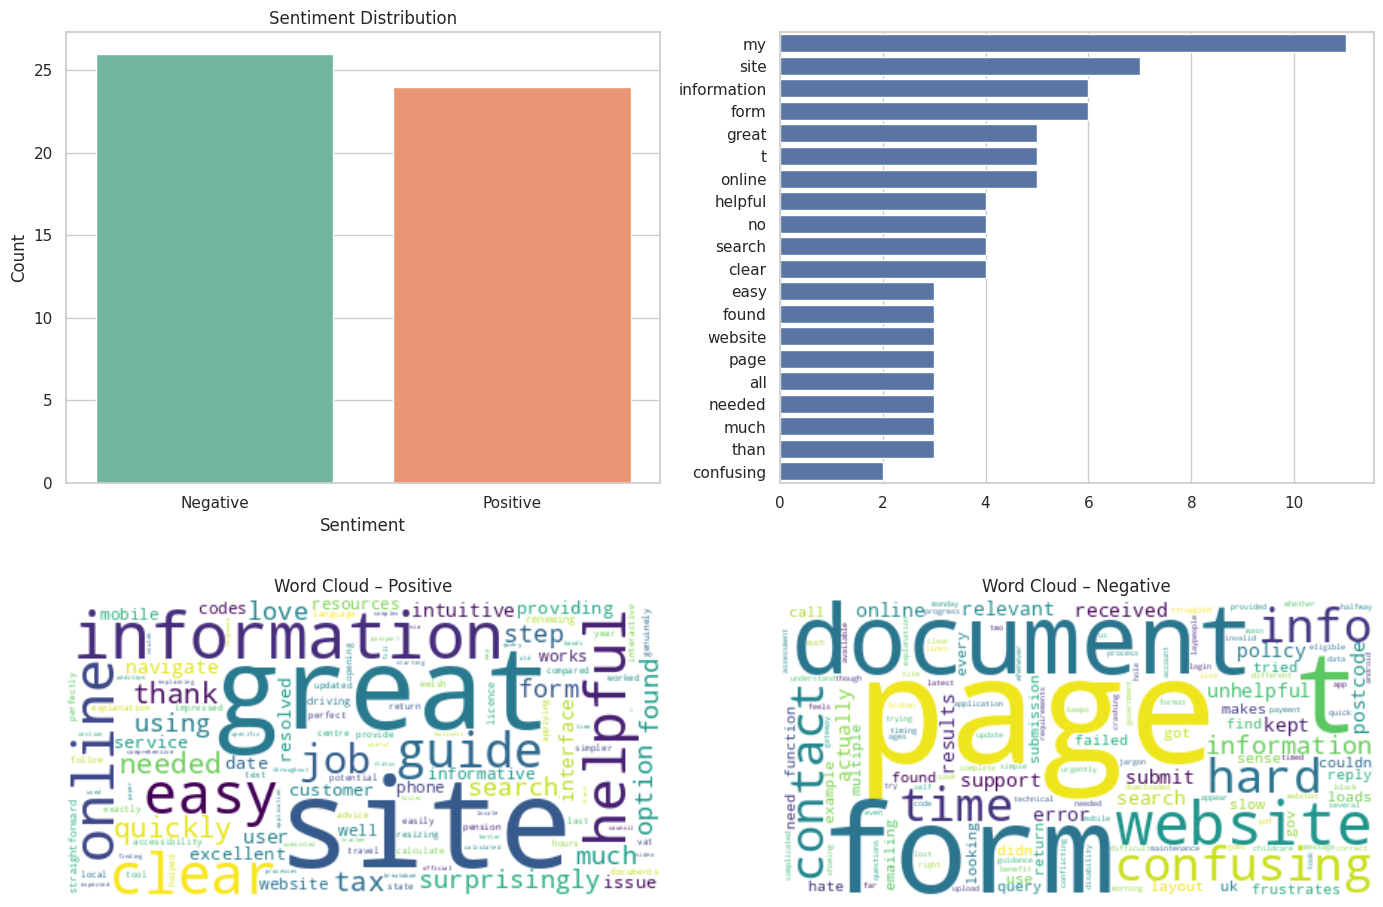

In [112]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sentiment distribution
sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    ax=axes[0, 0],palette='Set2'
)
axes[0, 0].set_title("Sentiment Distribution")
axes[0, 0].set_ylabel("Count")

# Top‑20 words overall
words, freqs = zip(*top20)
sns.barplot(
    x=list(freqs),
    y=list(words),
    ax=axes[0, 1]
)
# Word cloud – Positive
pos_text = " ".join(tok for tok in df[df["Sentiment"] == "Positive"]["tokens"].explode())
wc_pos = WordCloud(width=400, height=200, background_color="white").generate(pos_text)
axes[1, 0].imshow(wc_pos, interpolation="bilinear")
axes[1, 0].set_title("Word Cloud – Positive")
axes[1, 0].axis("off")

# Word cloud – Negative
neg_text = " ".join(tok for tok in df[df["Sentiment"] == "Negative"]["tokens"].explode())
wc_neg = WordCloud(width=400, height=200, background_color="white").generate(neg_text)
axes[1, 1].imshow(wc_neg, interpolation="bilinear")
axes[1, 1].set_title("Word Cloud – Negative")
axes[1, 1].axis("off")

fig.tight_layout()
plt.show()


## Data Augmentation

#### NLPAug

In [113]:
import pandas as pd
import nlpaug.augmenter.word as naw

# Number of augmentations per original sample [trying N_AUG=2,3,5]
N_AUG = 5

# Initializing contextual based augmenter
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action='substitute', aug_p=0.3)
augmented_rows = []

#class counts could be used to balance augmentation (augment minority class more)
# [Feedback data is fairly balanced so not using double augumentation for minority class
# class_counts = df['Sentiment'].value_counts()
# minority_class = class_counts.idxmin()


# Iterating once through the data and augment each row the same number of times
for text, label in zip(df["Feedback"], df["Sentiment"]):
    for _ in range(N_AUG):
        try:
            augmented_text = aug.augment(text)
            augmented_rows.append({"Feedback": augmented_text, "Sentiment": label})
        except Exception as e:
            print(f"Augmentation error on text: {text} | Error: {e}")

# Creating augmented DataFrame
df_augmented = pd.DataFrame(augmented_rows)

# Combining original + augmented data
df_nlpaug = pd.concat([df, df_augmented], ignore_index=True)

print(f"Original size: {len(df)}")
print(f"Augmented size: {len(df_augmented)}")
print(f"Combined size: {len(df_nlpaug)}")

#augmented examples
print(df_nlpaug.sample(5))


Original size: 50
Augmented size: 250
Combined size: 300
                                              Feedback Sentiment tokens
209  [but can ' n they save my personal income thro...  Negative    NaN
277  [quick download track with passport applicatio...  Positive    NaN
144  [it wasn ' t clear during the start if i liked...  Negative    NaN
192  [a vat account form was gradually simpler over...  Positive    NaN
178  [why is there one standard webchat solution ne...  Negative    NaN


In [114]:
# Remove the 'tokens' columns from the combined dataframe
df_nlpaug = df_nlpaug.drop(columns=['tokens'], errors='ignore')
df_nlpaug.info() #chck for dtype and any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Feedback   300 non-null    object
 1   Sentiment  300 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [115]:
df_nlpaug['Sentiment'].value_counts() #check if augumented data is balanced

,count
Sentiment,
Negative,156
Positive,144


In [116]:
df_nlpaug.to_csv('NLPAug_augmented_feedback_data.csv', index=False) #data df_nlpaug to csv

#### LLM AUG

In [117]:
import os, getpass
openai_api_key = os.getenv('OPENAI_API_KEY') or getpass.getpass('OpenAI API key: ')
os.environ['OPENAI_API_KEY'] = ''
#inserted my openai api key
#attached the generated file in supporting documents for running this analysis
import openai
openai.api_key = openai_api_key

In [118]:
from typing import List

def generate_variations(text: str, label: str, n: int = 3, model: str = 'gpt-4o') -> List[str]:
    """Generate *n* paraphrases that keep the original sentiment label."""
    prompt = (
        f"You are an NLP assistant generating diverse paraphrases for data augmentation.\n"
        f"Your task is to produce {n} different English sentences that have the same overall sentiment ({label}) as the given sentence.\n"
        f"Original sentence:\n\"{text}\"\n"
        f"Return each new sentence on a separate line without numbering."
    )

    resp = openai.ChatCompletion.create(
        model="gpt-4o-mini",#using gpt-4o-mini model
        temperature=0.85,
        max_tokens=120,
        messages=[{"role": "user", "content": prompt}],
    )

    sentences = [s.strip() for s in resp.choices[0].message.content.split('\n') if s.strip()]
    return sentences[:n] #strip each sentence and return

In [119]:
def augment_dataset(df: pd.DataFrame, n_aug: int = 3, balance: bool = False) -> pd.DataFrame:
    augmented_rows = []
    # Determine target size per class if balancing
    if balance:
        class_counts = df['Sentiment'].value_counts()
        target_size = class_counts.max()
    else:
        target_size = None

    for _, row in df.iterrows():
        text, label = row['Feedback'], row['Sentiment']
        augmented_rows.append(row.to_dict())  # keep original

        # Decide how many augments for this sample
        if balance:
            label_count = (df['Sentiment'] == label).sum()
            this_n = max(n_aug, (target_size - label_count) // label_count if label_count else n_aug)
        else:
            this_n = n_aug

        try:
            new_sents = generate_variations(text, label, this_n)
            for s in new_sents:
                augmented_rows.append({"Feedback": s, "Sentiment": label})
        except Exception as e:
            print(f"[WARN] Generation failed for: {text[:30]}... -> {e}")
            continue

    return pd.DataFrame(augmented_rows)

In [120]:
n_aug = 5    # number of new examples per original #n=5 to balance nlpaug and comparing results
balance = True # ensuring class balancing

df_llm = augment_dataset(df, n_aug=n_aug, balance=balance)
print(f"Augmented dataset size: {len(df_llm)} (original {len(df)})")
display(df_llm.head())
print('\nNew label distribution:')
display(df_llm['Sentiment'].value_counts())

Augmented dataset size: 299 (original 50)


,Feedback,Sentiment,tokens
0,The information was very helpful and easy to n...,Positive,"[information, helpful, easy, navigate]"
1,The details provided were incredibly useful an...,Positive,NaN
2,I found the information to be extremely benefi...,Positive,NaN
3,The data was remarkably helpful and simple to ...,Positive,NaN
4,The insights shared were highly valuable and e...,Positive,NaN



New label distribution:


,count
Sentiment,
Negative,155
Positive,144


In [121]:
# remove column tokens in df_llm

df_llm = df_llm.drop(columns=['tokens'], errors='ignore')

In [122]:
df_llm.head()

,Feedback,Sentiment
0,The information was very helpful and easy to n...,Positive
1,The details provided were incredibly useful an...,Positive
2,I found the information to be extremely benefi...,Positive
3,The data was remarkably helpful and simple to ...,Positive
4,The insights shared were highly valuable and e...,Positive


In [123]:
df_llm.to_csv('llm_augmented_feedback_data.csv', index=False) #please find data attached as a supporting document for further analaysis

## Data Preprocessing



In [124]:
import nltk
from nltk.corpus import stopwords
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
STOP_WORDS = set(stopwords.words("english"))

In [138]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Duplication

In [139]:
def drop_exact_duplicates(df: pd.DataFrame, text_col: str) -> pd.DataFrame:
    #Dropping duplicate row, case insensitive
    return df.drop_duplicates(subset=text_col, keep="first")



### Sensitive Information Removal


In [140]:
EMAIL_RE = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b")
PHONE_RE = re.compile(r"\b(?:\+?\d{1,3}[-.\s])?(?:\(?\d{3}\)?[-.\s]?){1,2}\d{4}\b")
URL_RE   = re.compile(r"https?://\S+|www\.\S+")

def scrub_sensitive(text: str) -> str:
    #Masking  e‑mails, phone numbers, and URLs with placeholders
    text = EMAIL_RE.sub("[EMAIL]", text)
    text = PHONE_RE.sub("[PHONE]", text)
    text = URL_RE.sub("[URL]", text)
    return text

###Spam Filtering

In [141]:
def is_spam(text: str,
            min_alpha_ratio: float = 0.3,
            min_len: int = 15,
            max_rep: int = 6) -> bool:
    #flagging spams: very short text, few characters, repeated characters

    if len(text) < min_len:
        return True

    alpha_ratio = sum(ch.isalpha() for ch in text) / len(text)
    if alpha_ratio < min_alpha_ratio:
        return True

    if re.search(rf"(.)\1{{{max_rep},}}", text):
        return True

    return False

### Normalisation

In [142]:
PUNCT_DIGIT_RE = re.compile(r"[^A-Za-z\s]")   # keeping letters & space

def normalise(text: str) -> str:
    """
    • Unicode NFKC normalisation
    • Lower‑case
    • Strip accents
    • Remove punctuation & digits
    • Collapse multiple spaces
    """
    text = unicodedata.normalize("NFKC", text)
    text = text.lower()
    text = unicodedata.normalize(
        "NFKD", text
    ).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = PUNCT_DIGIT_RE.sub(" ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

### Tokenization

In [143]:
from nltk.tokenize import sent_tokenize,word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def tokenize(text: str) -> List[str]:
    """Word‑tokenise & drop stop‑words."""
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOP_WORDS]
    return tokens


###Sentiment lable mapping

In [144]:
LABEL_MAP = {"positive": 1, "negative": 0}

def map_sentiment(label) -> int:
# label mapping, case insensitive
    try:
        return LABEL_MAP[str(label).strip().lower()]
    except KeyError as e:
        raise ValueError(f"Unknown sentiment label: {label}") from e

## Preprocessing pipeline

In [145]:
import unicodedata
import re # Assuming re is used in scrub_sensitive or is_spam
def preprocess_dataframe(
    df: pd.DataFrame,
    text_col: str = "Feedback",
    label_col: str = "Sentiment",
) -> pd.DataFrame:

    # Exact‑text deduplication
    df = drop_exact_duplicates(df, text_col)

    # Sensitive‑info scrub + spam filter (row‑wise)
    cleaned_records = []
    for _, row in df.iterrows():
        text = scrub_sensitive(str(row[text_col]))

        if is_spam(text):
            continue  # dropping spam row

        text_norm = normalise(text)
        tokens = tokenize(text_norm)

        # Skippking empty token lists (after stop‑word removal)
        if not tokens:
            continue

        cleaned_records.append(
            {
                text_col: " ".join(tokens),     # tokenised text re‑joined
                f"{text_col}_tokens": tokens,
                label_col: map_sentiment(row[label_col]),
            }
        )

    return pd.DataFrame(cleaned_records)


In [146]:
if __name__ == "__main__":
    processed = preprocess_dataframe(df_nlpaug)
    print(processed.head())

                                Feedback  \
0      information helpful easy navigate   
1       found website confusing hard use   
2     great job user interface intuitive   
3  page loads slow frustrates every time   
4      thanks providing date information   

                                Feedback_tokens  Sentiment  
0        [information, helpful, easy, navigate]          1  
1        [found, website, confusing, hard, use]          0  
2      [great, job, user, interface, intuitive]          1  
3  [page, loads, slow, frustrates, every, time]          0  
4        [thanks, providing, date, information]          1  


#### df_nlp_preprocessed

In [147]:



df_nlpaug_clean = preprocess_dataframe(df_nlpaug,
                                text_col="Feedback",
                                label_col="Sentiment")

print(df_nlpaug_clean.describe(include="all"))

                                Feedback  \
count                                300   
unique                               298   
top     found website confusing hard use   
freq                                   2   
mean                                 NaN   
std                                  NaN   
min                                  NaN   
25%                                  NaN   
50%                                  NaN   
75%                                  NaN   
max                                  NaN   

                               Feedback_tokens   Sentiment  
count                                      300  300.000000  
unique                                     298         NaN  
top     [found, website, confusing, hard, use]         NaN  
freq                                         2         NaN  
mean                                       NaN    0.480000  
std                                        NaN    0.500435  
min                                        N

####df_llm_preprocessed

In [148]:

df_llm_clean = preprocess_dataframe(df_llm,
                                text_col="Feedback",
                                label_col="Sentiment")

print(df_llm_clean.describe(include="all"))

                          Feedback                  Feedback_tokens  \
count                          299                              299   
unique                         299                              299   
top     site incredible glad found  [site, incredible, glad, found]   
freq                             1                                1   
mean                           NaN                              NaN   
std                            NaN                              NaN   
min                            NaN                              NaN   
25%                            NaN                              NaN   
50%                            NaN                              NaN   
75%                            NaN                              NaN   
max                            NaN                              NaN   

         Sentiment  
count   299.000000  
unique         NaN  
top            NaN  
freq           NaN  
mean      0.481605  
std       0.500499  


In [151]:
df_nlpaug_clean= df_nlpaug_clean.drop(columns=['Feedback_tokens'], errors='ignore')

In [152]:
df_nlpaug_clean

,Feedback,Sentiment
0,information helpful easy navigate,1
1,found website confusing hard use,0
2,great job user interface intuitive,1
3,page loads slow frustrates every time,0
4,thanks providing date information,1
...,...,...
295,great site bad site great sites damn love,1
296,real site great website great site love still ...,1
297,huge site great site great site love us,1
298,great site great site great horror whatever,1


In [159]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_nlpaug_clean)

MessageError: Error: credential propagation was unsuccessful

In [153]:
df_llm_clean= df_llm_clean.drop(columns=['Feedback_tokens'], errors='ignore')

In [154]:
df_llm_clean

,Feedback,Sentiment
0,information helpful easy navigate,1
1,details provided incredibly useful straightfor...,1
2,found information extremely beneficial quite e...,1
3,data remarkably helpful simple navigate,1
4,insights shared highly valuable effortlessly a...,1
...,...,...
294,website fantastic absolutely adore,1
295,really enjoy site amazing get enough,1
296,awesome website truly love,1
297,absolutely love site wonderful,1


#APPENDIX [please use own Wandb Authentication code for running]

### NLPAUG data training and Evaluation

In [156]:
import pandas as pd, torch, numpy as np
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)
from sklearn.model_selection import train_test_split

df_nlpaug_clean = df_nlpaug_clean.dropna(subset=['Feedback', 'Sentiment'])          # safeguard

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_nlpaug_clean['Feedback'].tolist(),
    df_nlpaug_clean['Sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_nlpaug_clean['Sentiment']
)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True)
        self.labels    = labels
    def __len__(self):  return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


#  Train each model and store trainer / validation data

model_names    = ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base']
trainers_dict  = {}
valsets_dict   = {}
results_dict   = {}

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    p,r,f,_ = precision_recall_fscore_support(labels, preds, average='binary')
    acc     = accuracy_score(labels, preds)
    return {'accuracy':acc,'precision':p,'recall':r,'f1':f}

for model_name in model_names:
    print(f'\n Training {model_name}')
    tokenizer   = AutoTokenizer.from_pretrained(model_name)
    model       = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Same split for all models
    val_texts, val_labels = test_texts, test_labels   # rename for clarity
    train_ds  = SentimentDataset(train_texts, train_labels, tokenizer)
    val_ds    = SentimentDataset(val_texts,   val_labels,   tokenizer)

    args = TrainingArguments(
        output_dir=f'./results/{model_name.replace("/","_")}',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,

        logging_dir='./logs',
        seed=42
    )
    trainer = Trainer(model=model,
                      args=args,
                      train_dataset=train_ds,
                      eval_dataset=val_ds,
                      compute_metrics=compute_metrics)

    trainer.train()
    res = trainer.evaluate()
    print(res)

    # save for later evaluation
    trainers_dict[model_name] = trainer
    valsets_dict[model_name]  = val_ds
    results_dict[model_name]  = res


 Training bert-base-uncased


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.self.value.bias, bert.embeddings.token_type_embeddings.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.key.bias, bert.pooler.dense.weight, classifier.weight, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.lay

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thisisvaishnavibalaji (thisisvaishnavibalaji-curenetics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


{'eval_loss': 0.22149251401424408, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9, 'eval_recall': 0.9310344827586207, 'eval_f1': 0.9152542372881356, 'eval_runtime': 3.6807, 'eval_samples_per_second': 16.301, 'eval_steps_per_second': 0.272, 'epoch': 3.0}

 Training distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

The following layers were not sharded: pre_classifier.bias, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, pre_classifier.weight, distilbert.embeddings.LayerNorm.weight, classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.embeddings.LayerNorm.bias, classifier.bias, distilb

Step,Training Loss


{'eval_loss': 0.20045827329158783, 'eval_accuracy': 0.9333333333333333, 'eval_precision': 0.9032258064516129, 'eval_recall': 0.9655172413793104, 'eval_f1': 0.9333333333333333, 'eval_runtime': 1.5946, 'eval_samples_per_second': 37.627, 'eval_steps_per_second': 0.627, 'epoch': 3.0}

 Training roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

The following layers were not sharded: roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.bias, classifier.dense.weight, roberta.embeddings.token_type_embeddings.weight, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.value.weight, classifier.dense.bias, roberta.embeddings.word_embeddings.weight, roberta.embeddings.LayerNorm.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.query.bias, classifier.out_proj.weight, roberta.encoder.layer.*.attention.self.query.weight, classifier.out_proj.bias, roberta.encoder.layer.*.output.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.bias, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.bias, roberta.enco

Step,Training Loss


{'eval_loss': 0.2571287453174591, 'eval_accuracy': 0.9333333333333333, 'eval_precision': 0.9629629629629629, 'eval_recall': 0.896551724137931, 'eval_f1': 0.9285714285714286, 'eval_runtime': 2.9788, 'eval_samples_per_second': 20.142, 'eval_steps_per_second': 0.336, 'epoch': 3.0}


  Evaluating bert-base-uncased


  Evaluating distilbert-base-uncased


  Evaluating roberta-base



===== bert-base-uncased =====
              precision    recall  f1-score   support

    Negative       0.93      0.90      0.92        31
    Positive       0.90      0.93      0.92        29

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60


===== distilbert-base-uncased =====
              precision    recall  f1-score   support

    Negative       0.97      0.90      0.93        31
    Positive       0.90      0.97      0.93        29

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60


===== roberta-base =====
              precision    recall  f1-score   support

    Negative       0.91      0.97      0.94        31
    Positive       0.96      0.90      0.93        29

    accuracy                           0.93        60
   macro avg       0.94      0.93 

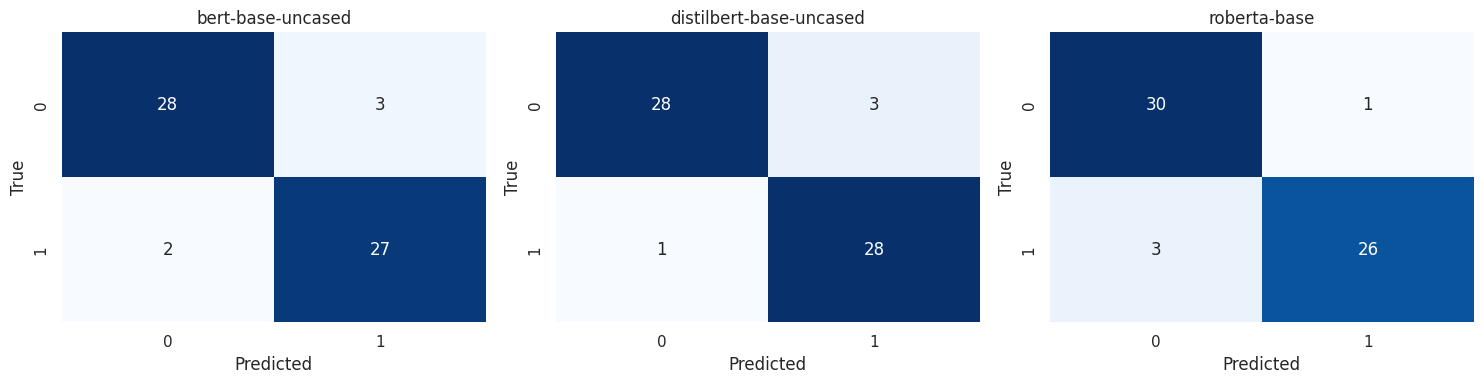

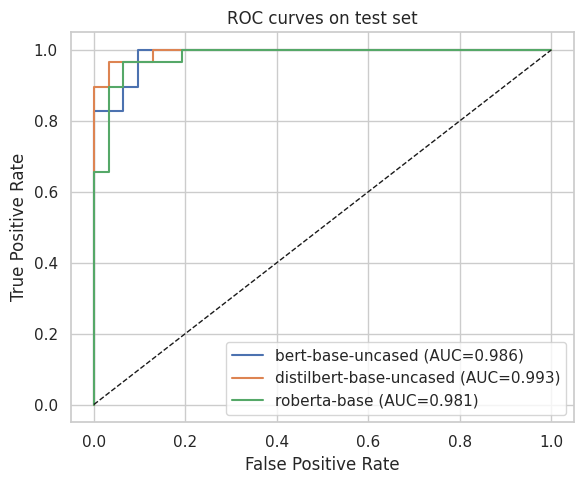

In [157]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from scipy.special import softmax
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc)

def evaluate_one(trainer, dataset, y_true):
    logits = trainer.predict(dataset).predictions
    y_pred = logits.argmax(-1)
    y_prob = softmax(logits, axis=1)[:,1]          # P(Positive)

    report = classification_report(y_true, y_pred,
                                   target_names=['Negative','Positive'],
                                   output_dict=True)
    cm     = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val     = auc(fpr, tpr)
    return {'y_pred':y_pred,'y_prob':y_prob,'report':report,
            'cm':cm,'fpr':fpr,'tpr':tpr,'auc':auc_val}

########################################################################
#  Run evaluation for NLP AUG DATASET
########################################################################
all_metrics = []
for name, trainer in trainers_dict.items():
    print(f'  Evaluating {name}')
    y_true  = np.array(test_labels)        # same ground‑truth for all
    metric  = evaluate_one(trainer, valsets_dict[name], y_true)
    metric['name'] = name
    all_metrics.append(metric)

########################################################################
#  1) Classification reports
########################################################################
for m in all_metrics:
    print(f'\n===== {m["name"]} =====')
    print(classification_report(test_labels, m['y_pred'],
                                target_names=['Negative','Positive']))

########################################################################
#  2) Confusion‑matrix heat‑maps
########################################################################
fig, axes = plt.subplots(1, len(all_metrics), figsize=(5*len(all_metrics),4))
if len(all_metrics)==1: axes=[axes]
for ax, m in zip(axes, all_metrics):
    sns.heatmap(m['cm'], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(m['name']); ax.set_xlabel('Predicted'); ax.set_ylabel('True')
plt.tight_layout(); plt.show()

########################################################################
#  3) ROC curves
########################################################################
plt.figure(figsize=(6,5))
for m in all_metrics:
    plt.plot(m['fpr'], m['tpr'], label=f"{m['name']} (AUC={m['auc']:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curves on test set'); plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

###LLM data training and *Evaluation*

In [158]:
import pandas as pd, torch, numpy as np
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)
from sklearn.model_selection import train_test_split

df_llm_clean = df_llm_clean.dropna(subset=['Feedback', 'Sentiment'])          # safeguard

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_llm_clean['Feedback'].tolist(),
    df_llm_clean['Sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_llm_clean['Sentiment']
)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True)
        self.labels    = labels
    def __len__(self):  return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


#  Train each model and store trainer / validation data

model_names    = ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base']
trainers_dict  = {}
valsets_dict   = {}
results_dict   = {}

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    p,r,f,_ = precision_recall_fscore_support(labels, preds, average='binary')
    acc     = accuracy_score(labels, preds)
    return {'accuracy':acc,'precision':p,'recall':r,'f1':f}

for model_name in model_names:
    print(f'\n Training {model_name}')
    tokenizer   = AutoTokenizer.from_pretrained(model_name)
    model       = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Same split for all models
    val_texts, val_labels = test_texts, test_labels   # rename for clarity
    train_ds  = SentimentDataset(train_texts, train_labels, tokenizer)
    val_ds    = SentimentDataset(val_texts,   val_labels,   tokenizer)

    args = TrainingArguments(
        output_dir=f'./results/{model_name.replace("/","_")}',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,

        logging_dir='./logs',
        seed=42
    )
    trainer = Trainer(model=model,
                      args=args,
                      train_dataset=train_ds,
                      eval_dataset=val_ds,
                      compute_metrics=compute_metrics)

    trainer.train()
    res = trainer.evaluate()
    print(res)

    # save for later evaluation
    trainers_dict[model_name] = trainer
    valsets_dict[model_name]  = val_ds
    results_dict[model_name]  = res


 Training bert-base-uncased


The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.self.value.bias, bert.embeddings.token_type_embeddings.weight, bert.pooler.dense.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.key.bias, bert.pooler.dense.weight, classifier.weight, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.lay

Step,Training Loss


{'eval_loss': 0.11511065810918808, 'eval_accuracy': 0.9833333333333333, 'eval_precision': 0.9666666666666667, 'eval_recall': 1.0, 'eval_f1': 0.9830508474576272, 'eval_runtime': 1.9457, 'eval_samples_per_second': 30.837, 'eval_steps_per_second': 0.514, 'epoch': 3.0}

 Training distilbert-base-uncased


The following layers were not sharded: pre_classifier.bias, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, pre_classifier.weight, distilbert.embeddings.LayerNorm.weight, classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.embeddings.LayerNorm.bias, classifier.bias, distilb

Step,Training Loss


{'eval_loss': 0.12764061987400055, 'eval_accuracy': 0.9666666666666667, 'eval_precision': 0.9655172413793104, 'eval_recall': 0.9655172413793104, 'eval_f1': 0.9655172413793104, 'eval_runtime': 1.3134, 'eval_samples_per_second': 45.683, 'eval_steps_per_second': 0.761, 'epoch': 3.0}

 Training roberta-base


The following layers were not sharded: roberta.encoder.layer.*.intermediate.dense.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.attention.output.dense.bias, classifier.dense.weight, roberta.embeddings.token_type_embeddings.weight, roberta.embeddings.position_embeddings.weight, roberta.encoder.layer.*.attention.self.value.weight, classifier.dense.bias, roberta.embeddings.word_embeddings.weight, roberta.embeddings.LayerNorm.weight, roberta.encoder.layer.*.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.query.bias, classifier.out_proj.weight, roberta.encoder.layer.*.attention.self.query.weight, classifier.out_proj.bias, roberta.encoder.layer.*.output.dense.weight, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.encoder.layer.*.attention.self.key.bias, roberta.encoder.layer.*.attention.self.key.weight, roberta.encoder.layer.*.attention.output.LayerNorm.bias, roberta.encoder.layer.*.intermediate.dense.bias, roberta.enco

Step,Training Loss


{'eval_loss': 0.11760048568248749, 'eval_accuracy': 0.9666666666666667, 'eval_precision': 0.9655172413793104, 'eval_recall': 0.9655172413793104, 'eval_f1': 0.9655172413793104, 'eval_runtime': 2.0864, 'eval_samples_per_second': 28.758, 'eval_steps_per_second': 0.479, 'epoch': 3.0}


  Evaluating bert-base-uncased


  Evaluating distilbert-base-uncased


  Evaluating roberta-base



===== bert-base-uncased =====
              precision    recall  f1-score   support

    Negative       1.00      0.97      0.98        31
    Positive       0.97      1.00      0.98        29

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60


===== distilbert-base-uncased =====
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97        31
    Positive       0.97      0.97      0.97        29

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60


===== roberta-base =====
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97        31
    Positive       0.97      0.97      0.97        29

    accuracy                           0.97        60
   macro avg       0.97      0.97 

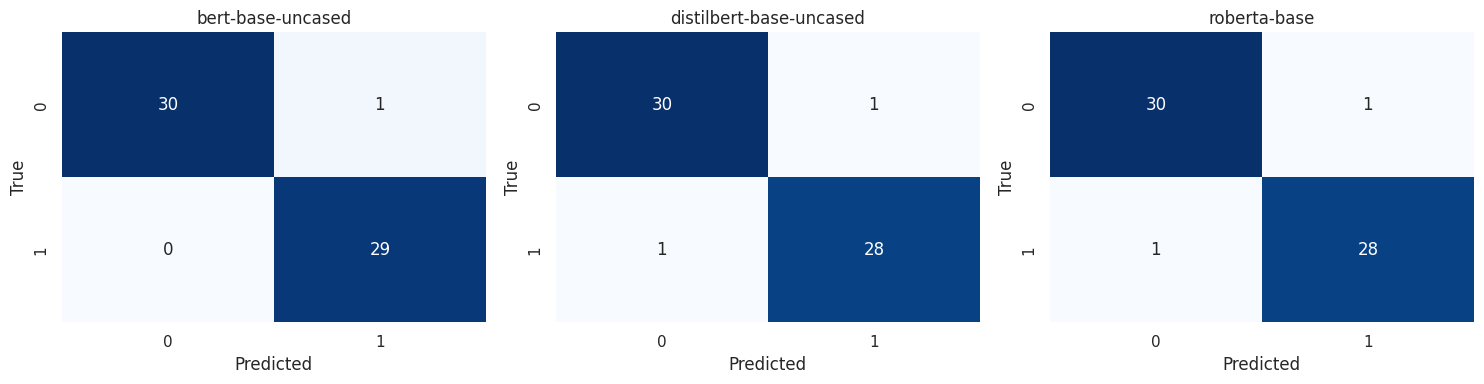

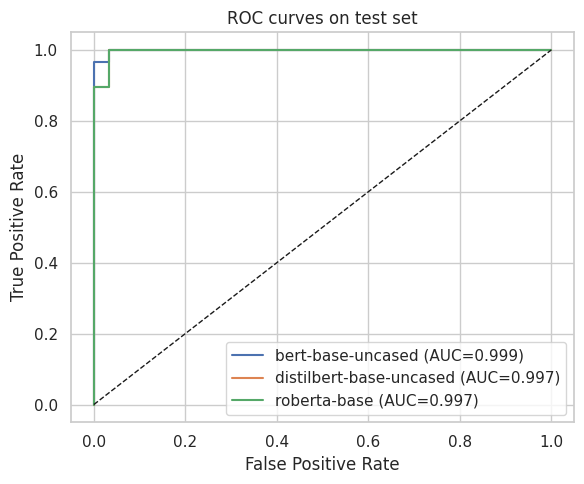

In [160]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from scipy.special import softmax
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc)

def evaluate_one(trainer, dataset, y_true):
    logits = trainer.predict(dataset).predictions
    y_pred = logits.argmax(-1)
    y_prob = softmax(logits, axis=1)[:,1]          # P(Positive)

    report = classification_report(y_true, y_pred,
                                   target_names=['Negative','Positive'],
                                   output_dict=True)
    cm     = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val     = auc(fpr, tpr)
    return {'y_pred':y_pred,'y_prob':y_prob,'report':report,
            'cm':cm,'fpr':fpr,'tpr':tpr,'auc':auc_val}

########################################################################
#  Run evaluation for NLP AUG DATASET
########################################################################
all_metrics = []
for name, trainer in trainers_dict.items():
    print(f'  Evaluating {name}')
    y_true  = np.array(test_labels)        # same ground‑truth for all
    metric  = evaluate_one(trainer, valsets_dict[name], y_true)
    metric['name'] = name
    all_metrics.append(metric)

########################################################################
#  1) Classification reports
########################################################################
for m in all_metrics:
    print(f'\n===== {m["name"]} =====')
    print(classification_report(test_labels, m['y_pred'],
                                target_names=['Negative','Positive']))

########################################################################
#  2) Confusion‑matrix heat‑maps
########################################################################
fig, axes = plt.subplots(1, len(all_metrics), figsize=(5*len(all_metrics),4))
if len(all_metrics)==1: axes=[axes]
for ax, m in zip(axes, all_metrics):
    sns.heatmap(m['cm'], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(m['name']); ax.set_xlabel('Predicted'); ax.set_ylabel('True')
plt.tight_layout(); plt.show()

########################################################################
#  3) ROC curves
########################################################################
plt.figure(figsize=(6,5))
for m in all_metrics:
    plt.plot(m['fpr'], m['tpr'], label=f"{m['name']} (AUC={m['auc']:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curves on test set'); plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()